In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
from matplotlib.colors import Normalize
from matplotlib.ticker import PercentFormatter
from utils import *

In [2]:
t_start = 0                                     # Start day
t_end = 180                                     # End day
t_points = 500                                  # No. time points
t = np.linspace(t_start,t_end,t_points)         # Define time array
t_interval = (t_end - t_start)/(t_points-1)     # Calculate time interval

# Intranasal prophylaxis

In [3]:
# Define parameter values
q_passive = 0.01
R0 = 2
p = 0.9
gamma_m = 1/4.4
gamma_s = 1/4
epsilon_ss = 0.66
beta = R0*gamma_m*gamma_s/(p*gamma_s + (1-p)*gamma_m)
beta_m = beta
beta_m2 = beta
beta_s = beta
beta_s2 = beta
a = 1/2
c = 0.75
N = 1e5
I_m0 = 1
I_s0 = 0

# Define initial conditions and parameter values
# S, S_s, E, I_m, I_s, R = y
y0_passive = [N-(I_m0 + I_s0), 0, 0, I_m0, I_s0, 0]
k_passive = [q_passive, beta_m, beta_m2, beta_s, beta_s2, gamma_m, gamma_s, epsilon_ss, c, a, p, N]
k_none = [0, beta_m, beta_m2, beta_s, beta_s2, gamma_m, gamma_s, epsilon_ss, c, a, p, N]

# Solve ODEs
y_passive = odeint(passive_model, y0_passive, t, args=(k_passive,))
y_none = odeint(passive_model, y0_passive, t, args=(k_none,))

# Vaccination

In [4]:
# Define parameter values
q_active = 0.01
q_v1 = 1/21
q_v2 = 1/21
beta_m = beta
beta_v1m = beta
beta_v2m = beta
beta_s = beta
beta_v1s = beta
beta_v2s = beta
gamma_m = 1/4.4
gamma_s = 1/4
epsilon_1 = 0.2*0.66
epsilon_2 = 0.66
c = 0.75

# Define initial conditions and parameter values
y0_active = [N-1, 0, 0, 0, 0, I_m0, I_s0, 0]

In [7]:
# Sensitivity scenarios
n_steps = 100   # Number of coverage and efficacy scenarios
epsilon_array = np.linspace(0.5,0.9,n_steps)    # Array of efficacy scenarios
coverage_array = np.linspace(0.5,0.9,n_steps)     # Array of coverage scenarios
uptake_array = [0.01, 0.03] # Array of uptake scenarios

# Initialise results array
end_averted_passive = np.zeros(shape=(len(uptake_array), len(epsilon_array), len(coverage_array)))
end_averted_active = np.zeros(shape=(len(uptake_array), len(epsilon_array), len(coverage_array)))

In [8]:
for k, uptake in enumerate(uptake_array):
    for i, epsilon in enumerate(epsilon_array):
        for j, coverage in enumerate(coverage_array):
            # Define parameter values
            k_passive = [uptake, beta_m, beta_m2, beta_s, beta_s2, gamma_m, gamma_s, epsilon, coverage, a, p, N]
            k_none = [0, beta_m, beta_m2, beta_s, beta_s2, gamma_m, gamma_s, epsilon, coverage, a, p, N]
            k_active = [uptake, q_v1, q_v2, beta_m, beta_v1m, beta_v2m, beta_s, beta_v1s, beta_v2s, gamma_m, gamma_s, 0.2*epsilon, epsilon, coverage, a, p, N]

            # Solve ODEs
            y_passive = odeint(passive_model, y0_passive, t, args=(k_passive,))
            y_none = odeint(passive_model, y0_passive, t, args=(k_none,))
            y_active = odeint(active_model, y0_active, t, args=(k_active,))

            # Calculate cumulative number of infections in each scenario
            cumul_infections_passive = np.cumsum(a*y_passive[:,2]*t_interval)
            cumul_infections_active = np.cumsum(a*y_active[:,4]*t_interval)
            cumul_infections_none = np.cumsum(a*y_none[:,2]*t_interval)

            # Calculate the percentage of infections averted in each scenario
            n_averted_passive = 1 - (cumul_infections_passive)/(cumul_infections_none)
            n_averted_active = 1 - (cumul_infections_active)/(cumul_infections_none)

            # Append results to array
            end_averted_passive[k,i,j] = n_averted_passive[-1]
            end_averted_active[k,i,j] = n_averted_active[-1]

        

/var/folders/43/ll9hmb7s3hl062ybcfj94br80000gn/T/ipykernel_19436/3568228263.py:17: RuntimeWarning: invalid value encountered in divide
  n_averted_passive = 1 - (cumul_infections_passive)/(cumul_infections_none)
/var/folders/43/ll9hmb7s3hl062ybcfj94br80000gn/T/ipykernel_19436/3568228263.py:18: RuntimeWarning: invalid value encountered in divide
  n_averted_active = 1 - (cumul_infections_active)/(cumul_infections_none)


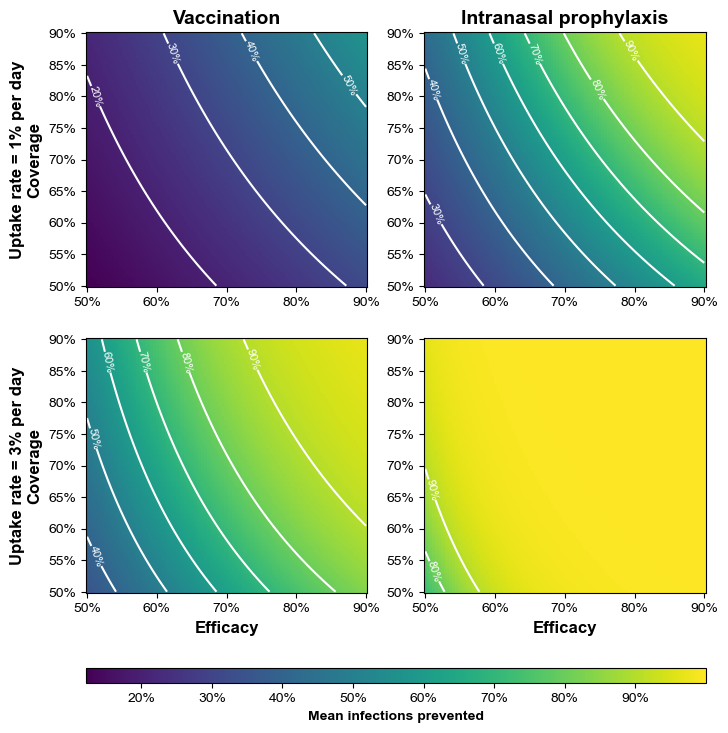

In [15]:
# Create a meshgrid for the axes
Epsilon, Coverage = np.meshgrid(epsilon_array, coverage_array)

plt.rcParams['font.family'] = 'Arial'

fig, axes = plt.subplots(2, 2, figsize=(8, 11))

cmap = 'viridis'

# Plotting for the first subplot
pcm1 = axes[0,0].pcolormesh(Epsilon, Coverage, end_averted_active[0].T, cmap=cmap, rasterized=True)
contours1 = axes[0,0].contour(Epsilon, Coverage, end_averted_active[0].T, levels=np.arange(0, 1.01, 0.1), colors='white')
axes[0,0].clabel(contours1, inline=True, fontsize=8, fmt=lambda x: f'{x:.0%}')
axes[0,0].set_ylabel('Uptake rate = 1% per day\nCoverage', fontweight='bold', fontsize=12)
axes[0,0].xaxis.set_major_formatter(PercentFormatter(1, decimals=0))
axes[0,0].yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
axes[0,0].set_title('Vaccination', fontweight='bold', fontsize=14)

# Plotting for the second subplot
pcm2 = axes[0,1].pcolormesh(Epsilon, Coverage, end_averted_passive[0].T, cmap=cmap, rasterized=True)
contours2 = axes[0,1].contour(Epsilon, Coverage, end_averted_passive[0].T,levels=np.arange(0, 1.01, 0.1), colors='white')
axes[0,1].clabel(contours2, inline=True, fontsize=8, fmt=lambda x: f'{x:.0%}')
axes[0,1].xaxis.set_major_formatter(PercentFormatter(1, decimals=0))
axes[0,1].yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
axes[0,1].set_title('Intranasal prophylaxis', fontweight='bold', fontsize=14)

# Plotting for the third subplot
pcm3 = axes[1,0].pcolormesh(Epsilon, Coverage, end_averted_active[1].T, cmap=cmap, rasterized=True)
contours3 = axes[1,0].contour(Epsilon, Coverage, end_averted_active[1].T, levels=np.arange(0, 1.01, 0.1), colors='white')
axes[1,0].clabel(contours3, inline=True, fontsize=8, fmt=lambda x: f'{x:.0%}')
axes[1,0].set_xlabel('Efficacy', fontweight='bold', fontsize=12)
axes[1,0].set_ylabel('Uptake rate = 3% per day\nCoverage', fontweight='bold', fontsize=12)
axes[1,0].xaxis.set_major_formatter(PercentFormatter(1, decimals=0))
axes[1,0].yaxis.set_major_formatter(PercentFormatter(1, decimals=0))

# Plotting for the fourth subplot
pcm4 = axes[1,1].pcolormesh(Epsilon, Coverage, end_averted_passive[1].T, cmap=cmap, rasterized=True)
contours4 = axes[1,1].contour(Epsilon, Coverage, end_averted_passive[1].T,levels=np.arange(0, 1.01, 0.1), colors='white')
axes[1,1].clabel(contours4, inline=True, fontsize=8, fmt=lambda x: f'{x:.0%}')
axes[1,1].set_xlabel('Efficacy', fontweight='bold', fontsize=12)
axes[1,1].xaxis.set_major_formatter(PercentFormatter(1, decimals=0))
axes[1,1].yaxis.set_major_formatter(PercentFormatter(1, decimals=0))

# Linking the color limits of both plots
vmin = min(pcm1.get_clim()[0], pcm2.get_clim()[0], pcm3.get_clim()[0], pcm4.get_clim()[0])
vmax = max(pcm1.get_clim()[1], pcm2.get_clim()[1], pcm3.get_clim()[1], pcm4.get_clim()[1])
pcm1.set_clim(vmin, vmax)
pcm2.set_clim(vmin, vmax)
pcm3.set_clim(vmin, vmax)
pcm4.set_clim(vmin, vmax)

fig.subplots_adjust(bottom=0.2)

# Adding a shared colorbar at the bottom
cbar = fig.colorbar(pcm1, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.1, aspect=40, label='Mean infections prevented')
cbar.ax.xaxis.set_major_formatter(PercentFormatter(1, decimals=0))  # Set colorbar labels to percentage
cbar.set_label(label='Mean infections prevented', fontsize=10, weight='bold')

plt.show()

In [17]:
fig.savefig("../figures/Figure2.svg", bbox_inches=0)